https://avandekleut.github.io/vae/

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)


    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [42]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [43]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [44]:
def train(autoencoder, data, epochs=20):
    criterion = nn.MSELoss()
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        train_loss = 0.0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = criterion(x_hat, x)
            # loss = nn.MSELoss() # ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            
            train_loss += loss.item()*x.size(0)

        # print avg training statistics 
        train_loss = train_loss/len(data)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))
    return autoencoder

In [45]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

In [46]:
sum(p.numel() for p in autoencoder.parameters())

806674

In [7]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)

Epoch: 0 	Training Loss: 7.168985
Epoch: 1 	Training Loss: 6.106128
Epoch: 2 	Training Loss: 5.899102
Epoch: 3 	Training Loss: 5.776871
Epoch: 4 	Training Loss: 5.669011
Epoch: 5 	Training Loss: 5.577430
Epoch: 6 	Training Loss: 5.505027
Epoch: 7 	Training Loss: 5.447283
Epoch: 8 	Training Loss: 5.397144
Epoch: 9 	Training Loss: 5.352503
Epoch: 10 	Training Loss: 5.317453
Epoch: 11 	Training Loss: 5.282127
Epoch: 12 	Training Loss: 5.251811
Epoch: 13 	Training Loss: 5.220975
Epoch: 14 	Training Loss: 5.194779
Epoch: 15 	Training Loss: 5.166943
Epoch: 16 	Training Loss: 5.145340
Epoch: 17 	Training Loss: 5.119115
Epoch: 18 	Training Loss: 5.104108
Epoch: 19 	Training Loss: 5.081538


In [8]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

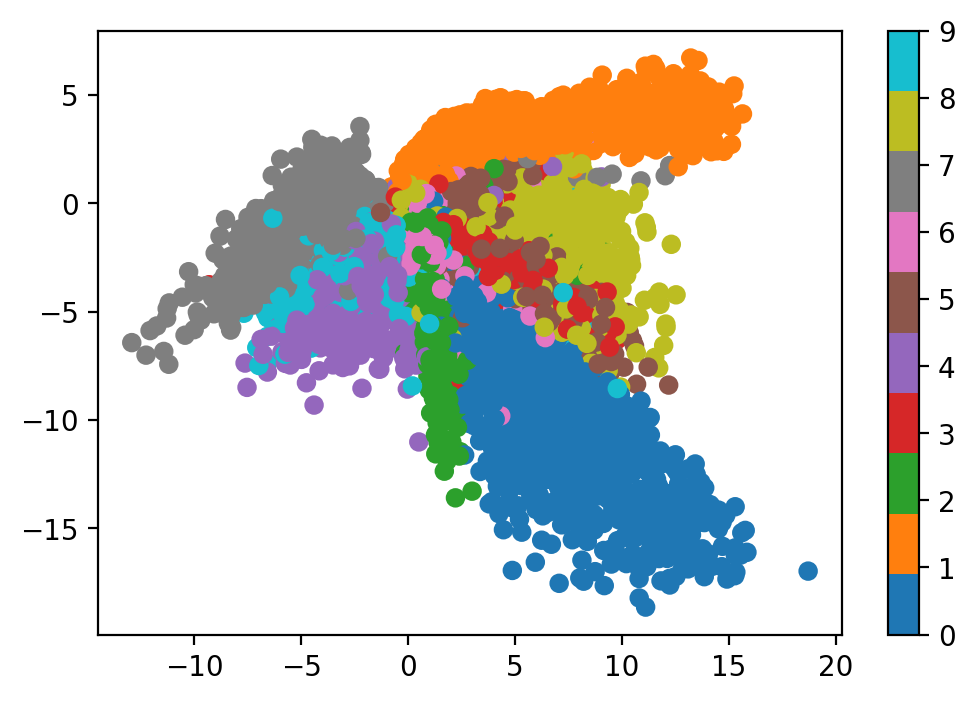

In [9]:
plot_latent(autoencoder, data)

In [10]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

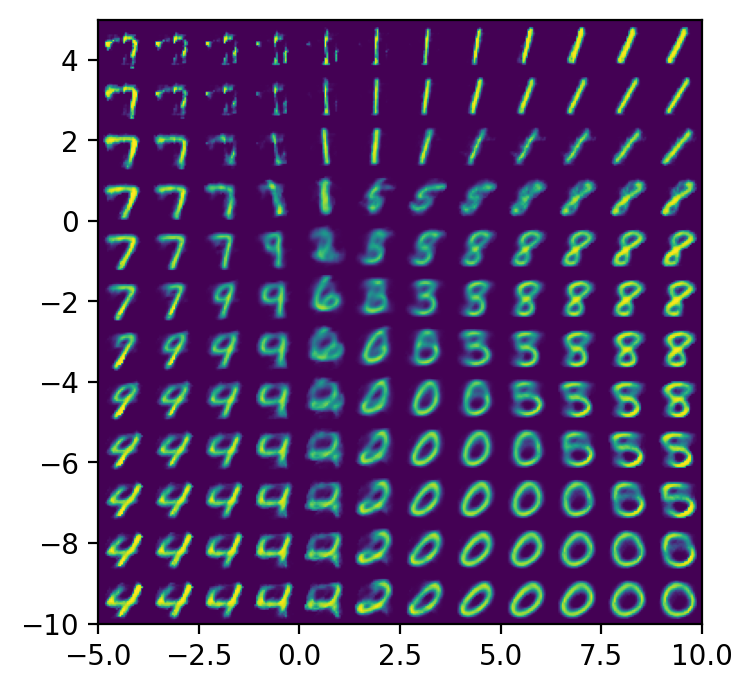

In [11]:
plot_reconstructed(autoencoder)

In [12]:
N = torch.distributions.Normal(0, 1)
N.loc, N.scale

(tensor(0.), tensor(1.))

In [13]:
N.sample((2,3))

tensor([[ 0.8311,  1.1368, -1.5417],
        [-0.4672,  1.1710,  0.6515]])

In [14]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1).sum()/2
        return z

In [15]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [16]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    # criterion = nn.MSELoss()
    for epoch in range(epochs):
        train_loss = 0.0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
            train_loss += loss.item()*x.size(0)
            
        # print avg training statistics 
        train_loss = train_loss/len(data)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))
    return autoencoder

In [17]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

Epoch: 0 	Training Loss: 774411.988406
Epoch: 1 	Training Loss: 662535.805087
Epoch: 2 	Training Loss: 641751.241621
Epoch: 3 	Training Loss: 627349.724680
Epoch: 4 	Training Loss: 616949.486141
Epoch: 5 	Training Loss: 609077.981843
Epoch: 6 	Training Loss: 602381.926389
Epoch: 7 	Training Loss: 597613.854178
Epoch: 8 	Training Loss: 593283.838036
Epoch: 9 	Training Loss: 590124.414212
Epoch: 10 	Training Loss: 586767.755380
Epoch: 11 	Training Loss: 583898.685018
Epoch: 12 	Training Loss: 580990.026536
Epoch: 13 	Training Loss: 579221.271105
Epoch: 14 	Training Loss: 576901.935601
Epoch: 15 	Training Loss: 575343.518607
Epoch: 16 	Training Loss: 572823.377965
Epoch: 17 	Training Loss: 571487.956656
Epoch: 18 	Training Loss: 570127.600863
Epoch: 19 	Training Loss: 568456.971915


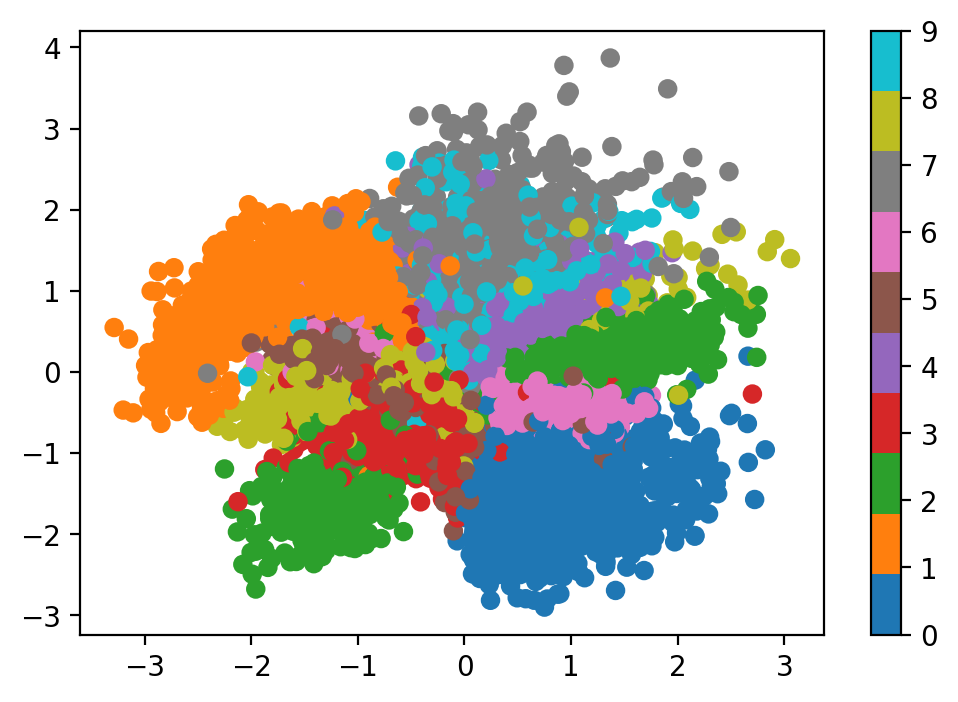

In [18]:
plot_latent(vae, data)

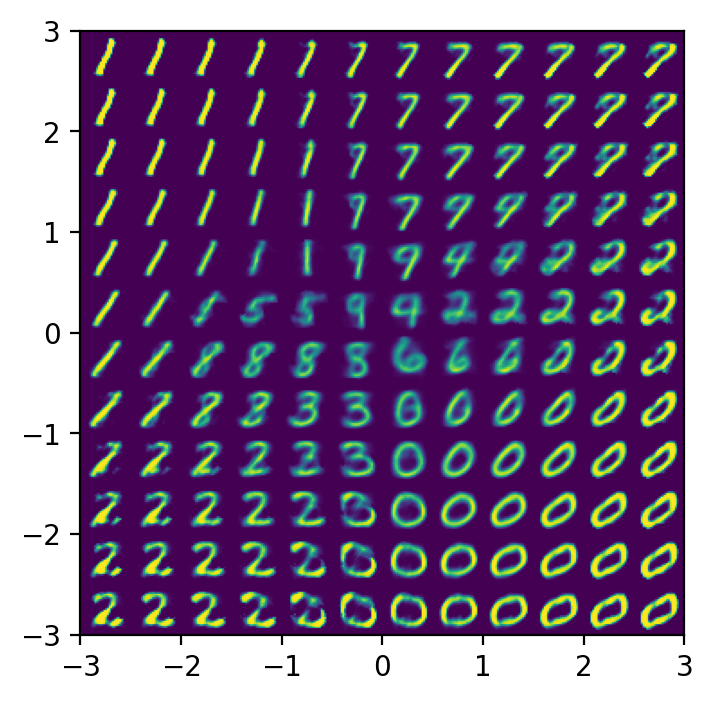

In [19]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

In [20]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [21]:
for x,y in data:
    x_1 = x[y == 1][1].to(device) # find a 1
    x_2 = x[y == 0][1].to(device) # find a 0
    break

In [22]:
x.shape

torch.Size([128, 1, 28, 28])

In [23]:
y.shape

torch.Size([128])

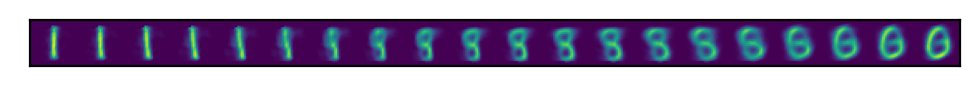

In [24]:
interpolate(vae, x_1, x_2, n=20)

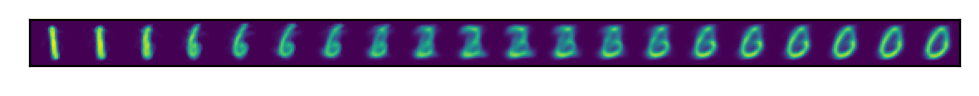

In [25]:
interpolate(autoencoder, x_1, x_2, n=20)

In [26]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)

In [27]:
interpolate_gif(vae, "vae", x_1, x_2)

<img src="vae.gif" width="200" align="center">

In [ ]:
class CNNNet(nn.Module):

    def __init__(self, num_classes=10):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
cnnnet = CNNNet().to(device)
print(cnnnet)

In [28]:
28*28

784

In [10]:
import torch.nn.functional as F
import torch
import numpy as np

In [29]:
inputs = torch.from_numpy(np.array([[[[1,2],[3,4]],[[5,6],[7,8]],[[9,10],[11, 12]]]]))
inputs.shape

torch.Size([1, 3, 2, 2])

In [34]:
inputs.sum()

tensor(78)

In [30]:
inputs

tensor([[[[ 1,  2],
          [ 3,  4]],

         [[ 5,  6],
          [ 7,  8]],

         [[ 9, 10],
          [11, 12]]]])

In [25]:
# filters = torch.from_numpy(np.array([[[[1,1,1],[1,1,1], [1, 1,1]],[[1,1,1],[1,1,1] ,
#                                                                    [1,1,1]],[[1,1,1],[1, 1,1], [1,1,1]]]]))
# filters.shape

In [31]:
filters = torch.from_numpy(np.array([[[[1,1],[1,1]],[[1,1],[1,1] ,
                                                                   ],[[1,1],[1, 1]]]]))
print(filters.shape)
filters

torch.Size([1, 3, 2, 2])


tensor([[[[1, 1],
          [1, 1]],

         [[1, 1],
          [1, 1]],

         [[1, 1],
          [1, 1]]]])

In [33]:
# filters

In [27]:
# inputs = torch.randn(1, 3, 2, 2)
# filters = torch.randn(1, 3, 3, 3)
out = F.conv2d(inputs, filters, padding=0)
print(out.shape)
out

torch.Size([1, 1, 1, 1])


tensor([[[[78]]]])

In [73]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(20, 50, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(50, 20, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))

        self.linear2 = nn.Linear(28 * 3 * 3, latent_dims)
        self.linear3 = nn.Linear(28 * 3 * 3, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1).sum()/2
        return z

In [74]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [75]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [76]:
def train(autoencoder, data, epochs=20):
    criterion = nn.MSELoss()
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        train_loss = 0.0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = criterion(x_hat, x)
            # loss = nn.MSELoss() # ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            
            train_loss += loss.item() * x.size(0)

        # print avg training statistics 
        train_loss = train_loss / len(data)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))
    return autoencoder

In [77]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

In [78]:
sum(p.numel() for p in autoencoder.parameters())

432822

In [79]:
autoencoder = train(autoencoder, data)

Epoch: 0 	Training Loss: 7.651137
Epoch: 1 	Training Loss: 6.286871
Epoch: 2 	Training Loss: 5.970396
Epoch: 3 	Training Loss: 5.802074
Epoch: 4 	Training Loss: 5.695363
Epoch: 5 	Training Loss: 5.615910
Epoch: 6 	Training Loss: 5.557132
Epoch: 7 	Training Loss: 5.488841
Epoch: 8 	Training Loss: 5.439940
Epoch: 9 	Training Loss: 5.393892
Epoch: 10 	Training Loss: 5.351459
Epoch: 11 	Training Loss: 5.314109
Epoch: 12 	Training Loss: 5.275519
Epoch: 13 	Training Loss: 5.251748
Epoch: 14 	Training Loss: 5.221149
Epoch: 15 	Training Loss: 5.202877
Epoch: 16 	Training Loss: 5.174091
Epoch: 17 	Training Loss: 5.159911
Epoch: 18 	Training Loss: 5.141746
Epoch: 19 	Training Loss: 5.118060
